<a href="https://colab.research.google.com/github/tahirmhd/DSAI-Project/blob/main/Copy_of_CV_lab_5_transfer_learning_and_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


In [ ]:
BATCH_SIZE = 32
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

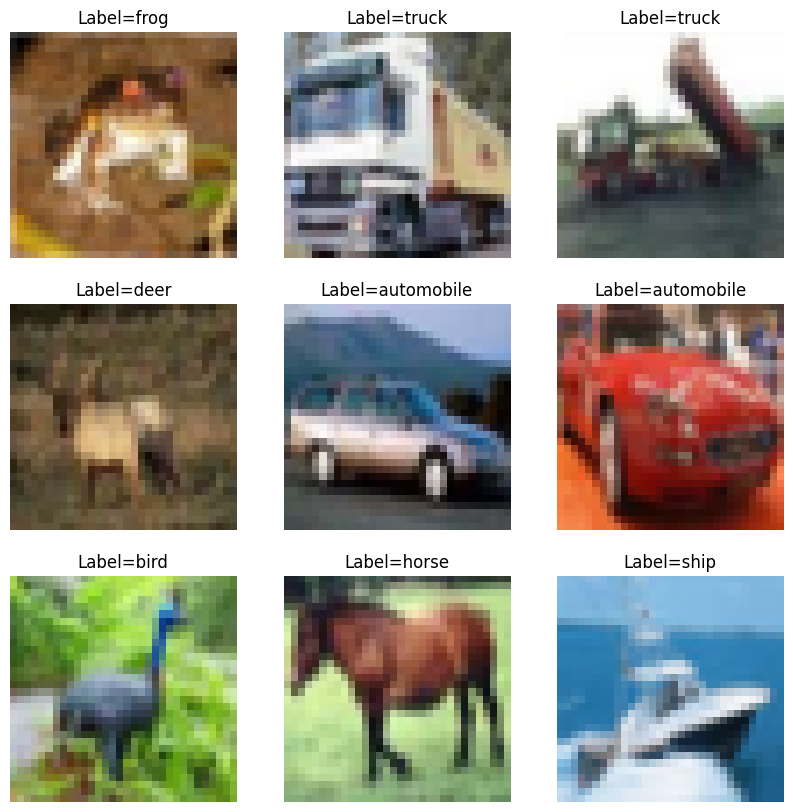

In [ ]:
# Create a subplot
plt.figure(figsize=(10, 10))
for i in range(9):
      # Display the image
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(training_images[i], cmap='gray')
      # Print the label
      plt.title("Label="+label_names[ training_labels[i][0]])
      plt.axis('off')

# Show the subplot
plt.show()

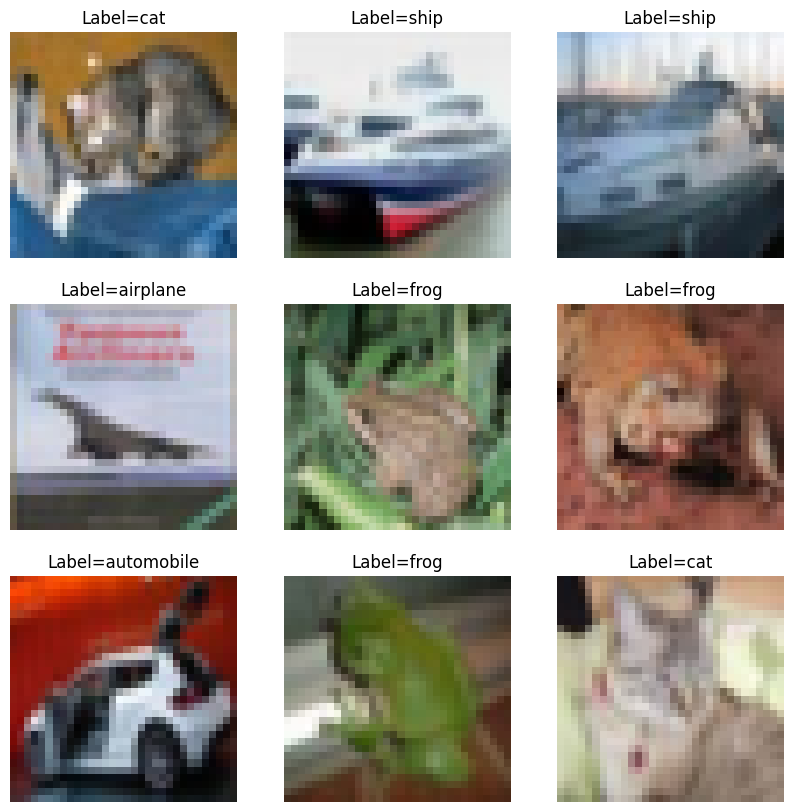

In [ ]:
# Create a subplot
plt.figure(figsize=(10, 10))
for i in range(9):
      # Display the image
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(validation_images[i], cmap='gray')
      # Print the label
      plt.title("Label="+label_names[ validation_labels[i][0]])
      plt.axis('off')

# Show the subplot
plt.show()

In [ ]:
#trfd=tf.keras.applications.resnet50.preprocess_input(training_images)

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [ ]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098

In [ ]:
EPOCHS = 3
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=128)

Epoch 1/3
391/391 [==============================] - 549s 1s/step - loss: 0.5355 - accuracy: 0.8290 - val_loss: 0.2337 - val_accuracy: 0.9239
Epoch 2/3
391/391 [==============================] - 519s 1s/step - loss: 0.1477 - accuracy: 0.9521 - val_loss: 0.1936 - val_accuracy: 0.9367
Epoch 3/3
391/391 [==============================] - 532s 1s/step - loss: 0.0626 - accuracy: 0.9822 - val_loss: 0.1803 - val_accuracy: 0.9400


In [ ]:
loss, t_accuracy = model.evaluate(train_X, training_labels, batch_size=64)

782/782 [==============================] - 140s 177ms/step - loss: 0.0306 - accuracy: 0.9942


In [ ]:
loss, v_accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 28s 175ms/step - loss: 0.1803 - accuracy: 0.9400


In [ ]:
print("Train Acc:",t_accuracy)
print("Test Acc:",v_accuracy)

Train Acc: 0.9941999912261963
Test Acc: 0.9399999976158142


1/1 [==============================] - 0s 23ms/step


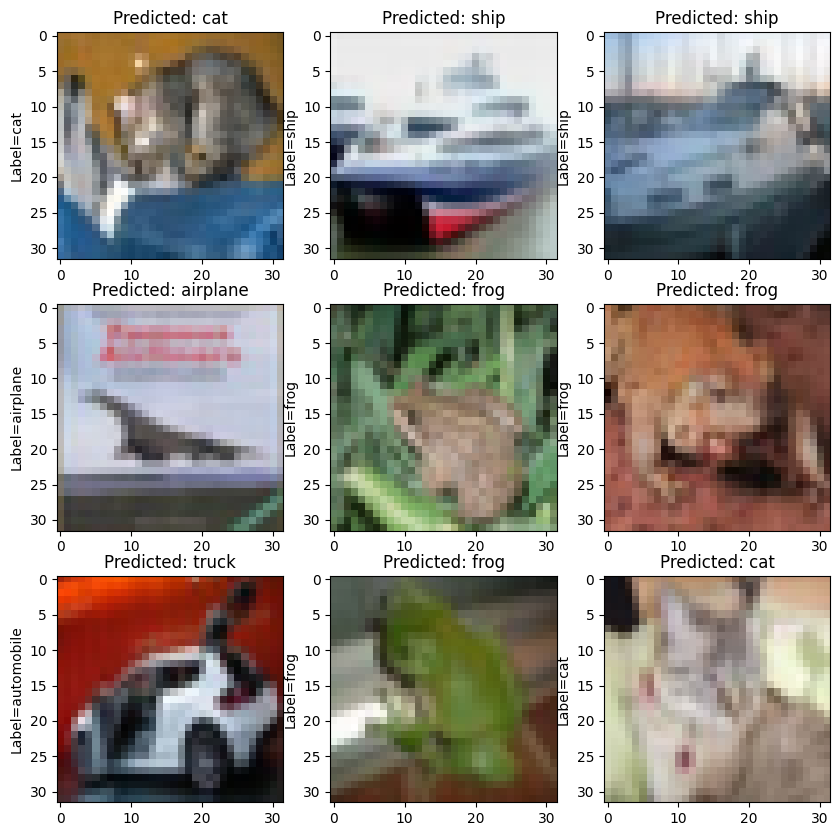

In [ ]:
# Predict the label for 9 images
test_images_9 = validation_images[:9]
test_labels_9 = validation_labels[:9]
# Create a subplot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
  test_images_9_1 = np.reshape(test_images_9[i], (1, 32, 32,3))
  prediction = model.predict(test_images_9_1)
  axes[i // 3, i % 3] = plt.subplot(3, 3, i + 1)
  axes[i // 3, i % 3].imshow(test_images_9[i])
  axes[i // 3, i % 3].set_title(f"Predicted: {label_names[prediction.argmax()] }")
  axes[i // 3, i % 3].set_ylabel("Label="+label_names[test_labels_9[i][0]])

plt.show()

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator class.
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

# Load the images.
train_X = datagen.flow(
    train_X,
    training_labels,
    batch_size=32,

)

valid_X = datagen.flow(
    valid_X,
    validation_labels,
    batch_size=32,

)


In [ ]:
EPOCHS = 3
history = model.fit(train_X, epochs=3, validation_data = (valid_X), batch_size=64)

Epoch 1/3
1563/1563 [==============================] - 562s 355ms/step - loss: 0.6628 - accuracy: 0.7712 - val_loss: 0.5674 - val_accuracy: 0.8064
Epoch 2/3
1563/1563 [==============================] - 543s 347ms/step - loss: 0.4542 - accuracy: 0.8414 - val_loss: 0.4537 - val_accuracy: 0.8399
Epoch 3/3
1563/1563 [==============================] - 553s 353ms/step - loss: 0.3836 - accuracy: 0.8663 - val_loss: 0.3797 - val_accuracy: 0.8715


In [ ]:
loss, t_accuracy = model.evaluate(train_X, training_labels, batch_size=64)
loss, v_accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)
print("Train Acc:",t_accuracy)
print("Test Acc:",v_accuracy)

ValueError: ignored